### Spam link detection system
We want to implement a system that is able to automatically detect whether a web page contains spam or not based on its URL.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import re 
import nltk 
from wordcloud import WordCloud
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay)
from nltk.corpus import stopwords
from nltk import ngrams
from scipy.stats import norm
nltk.download("stopwords")
stop_words = stopwords.words("english") # stopwords palabras de relleno

# Análisis de texto clásico ciertas palabras no añaden contexto y en base al resto de palabras podemos entender las relaciones que permitan hacer la clasficación
# Función para quitar los stopwords del data frame
def remove_stopwords(text):
    clean_text = []
    text = text.lower()
    if text is not None:
        words = text.split()
        for word in words:
            if word not in stop_words:
                clean_text.append(word)
        return " ".join(clean_text)
    else:
        return None


def remove_symbols(text):
    if text is not None:
        text = re.sub(r'''[.,?*&'"+${}-]''','',text) # Sub sustituir 
        return text
    else:
        return None

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# 1. Load data
df_raw = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [12]:
df_raw.sample(10)

,url,is_spam
1842,https://www.usatoday.com/story/money/2020/06/2...,False
182,https://www.bloomberg.com/tosv2.html,True
2256,https://www.coronavirus.gov/,True
860,https://www.globalcitizen.org/en/connect/globa...,False
2728,https://www.statnews.com/feature/coronavirus/c...,False
1355,https://www.wework.com/info/the-future-of-work...,False
1644,https://www.youtube.com/watch?v=g9RUwrI1QAU&fe...,False
1742,https://www.qmunity.tech/qubes-camp,False
1600,https://www.morningbrew.com/daily/stories/2020...,False
2589,https://www.amsterdam.nl/bestuur-organisatie/o...,False


In [13]:
df_interim=(
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(" ", "_")
        .str.lower(), axis=1
    )   
)

df= df_interim.copy()


In [14]:
df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [15]:
df["url_clean"] = df["url"].apply(lambda x: remove_stopwords(x))
df["url_clean"] = df["url_clean"].apply(lambda x: remove_symbols(x))
df["url_clean"] = df["url_clean"].str.replace(":", "")
df["url_clean"] = df["url_clean"].str.replace("!", "")
df["url_clean"] = df["url_clean"].str.replace("(", "")
df["url_clean"] = df["url_clean"].str.replace(")", "")


In [16]:
df_train, df_test = train_test_split(df, test_size=.2, stratify=df["is_spam"], random_state=2024)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2399 entries, 952 to 1675
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        2399 non-null   object
 1   is_spam    2399 non-null   bool  
 2   url_clean  2399 non-null   object
dtypes: bool(1), object(2)
memory usage: 58.6+ KB


In [17]:
# Conteo de los valores booleanos
df_train["is_spam"].value_counts()

is_spam
False    1842
True      557
Name: count, dtype: int64

In [18]:
df_train.sample(10)

,url,is_spam,url_clean
122,https://www.vox.com/the-goods/21291573/summer-...,False,https//wwwvoxcom/thegoods/21291573/summerpools...
623,https://www.cnn.com/2020/06/23/politics/eu-us-...,False,https//wwwcnncom/2020/06/23/politics/euuscoron...
957,https://abcnews.go.com/US/nasa-dc-headquarters...,False,https//abcnewsgocom/us/nasadcheadquartershidde...
1665,https://www.ft.com/content/9446192a-aff1-4e95-...,False,https//wwwftcom/content/9446192aaff14e9593fba5...
1367,https://www.morningbrew.com/daily/r/,True,https//wwwmorningbrewcom/daily/r/
2949,https://www.king5.com/article/news/local/prote...,False,https//wwwking5com/article/news/local/protests...
56,https://www.hollywoodreporter.com/news/amc-the...,False,https//wwwhollywoodreportercom/news/amctheatre...
1799,https://www.primattoo.com/,False,https//wwwprimattoocom/
1026,https://www.perininetworks.com/terms-conditions/,True,https//wwwperininetworkscom/termsconditions/
2270,https://www.vox.com/policy-and-politics/213070...,False,https//wwwvoxcom/policyandpolitics/21307008/ru...


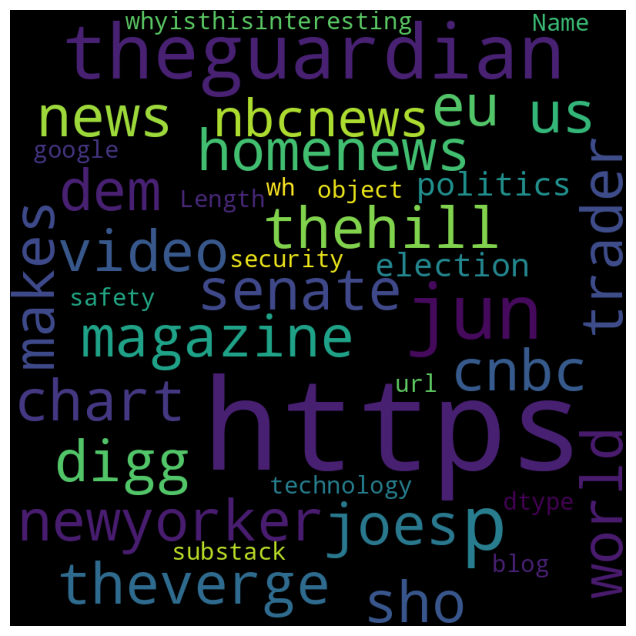

In [35]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df_train["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [19]:
X_train= df_train["url_clean"].reset_index(drop=True)
y_train = df_train["is_spam"].reset_index(drop=True)
X_test = df_test["url_clean"].reset_index(drop=True)
y_test = df_test["is_spam"].reset_index(drop=True)

In [20]:
# Vectorizador
count_vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True)
X_train_vec = count_vectorizer.fit_transform(X_train)
X_test_vec = count_vectorizer.transform(X_test)
X_train_vec

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 11411 stored elements and shape (2399, 3357)>

In [24]:
model = SVC(kernel = "rbf", C = 1.0, gamma = 0.5)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

In [25]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.9733333333333334


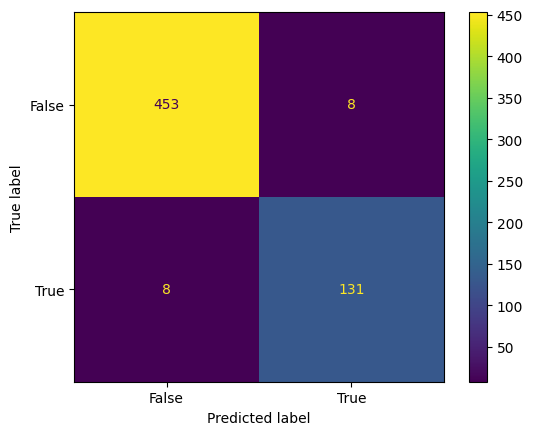

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [28]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

# We initialize the random search
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=SVC(gamma=0.5),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [30]:
grid.fit(X_train_vec, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 100, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


/workspaces/NLP/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/workspaces/NLP/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspaces/NLP/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/workspaces/NLP/.venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/worksp

In [31]:
opt_model = SVC(C = 1000, degree = 1, gamma = "auto", kernel = "poly", random_state = 42)
opt_model.fit(X_train_vec, y_train)
y_pred = opt_model.predict(X_test_vec)
accuracy_score(y_test, y_pred)

0.9616666666666667

In [36]:
from pickle import dump

dump(model, open("svm_classifier.sav", "wb"))